In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

y_train = tf.one_hot(np.squeeze(y_train), depth=10).numpy()
y_test = tf.one_hot(np.squeeze(y_test), depth=10).numpy()

In [3]:
def parser(tok, id, cls):
    ''' 
    SepConv: S,f,k,s
    MaxPool: P,s
    ReLU   : R
    Dropout: D
    '''
    if tok[0] == 'S':
        filters, ks, stride = list(map(int, tok[1:].split(',')))
        return SeparableConv2D(filters=filters, kernel_size=ks, strides=stride, 
                                padding='same', name=f'sepconv2d_d{id}_c{cls}')
    elif tok[0] == 'P':
        return MaxPool2D(pool_size=int(tok[1:]), name=f'MaxPool2D_d{id}_c{cls}')
    elif tok[0] == 'R':
        return ReLU(name=f'ReLU_d{id}_c{cls}')
    elif tok[0] == 'D':
        return Dropout(0.1, name=f'dropout_d{id}_c{cls}')
    elif tok[0] == 'N':
        return BatchNormalization()
    else:
        print('Invalid')


# How to define ensemble structure:
# S: SeparableConv2D, follows by filter, kernel, and stride 
#    example: S64,3,2
# P: MaxPool, followed by pool size
#    example: P2
# R: ReLU activation
# D: Dropout, defaults to 0.1 drop
#
# A full example: 'S8,3,2_R_D_S8,3,2_R_D'
# The network is as follows:
#    SeparableConv2D(filters=8, kernel_size=3, strides=2)
#    ReLU()
#    Dropout(0.1)
#    SeparableConv2D(filters=8, kernel_size=3, strides=2)
#    ReLU()
#    Dropout(0.1)


ensemble_structure = ['S64,3,2_R_D_S64,3,2_R_D',
                      'S32,3,2_R_D_S64,3,2_R_D',
                      'S16,3,2_R_D_S32,3,2_R_D', 
                      'S8,3,2_R_D_S8,3,2_R_D',
                      'S4,3,2_S16,3,2']


def Xception_block(input_shape, classes,
                   activation='sigmoid',
                   flows=7, 
                   ensemble='S16,3,2_R_D_S32,3,2_R_D',
                   loss='binary_crossentropy',
                   learning_rate=0.001,
                   weights='imagenet'):

    '''
    input_shape : input shape of image
    classes     : number of classes 
    breakindex  : number of xception block-flows to be used 
    ensemble    : the default ensemble model to be followed for each class
    '''

    assert flows > 0 and flows < 10, "The number of flows should be between [1-9]"
    assert loss in ['binary_crossentropy', 'categorical_crossentropy'], "loss can be either 'binary_crossentropy' or 'categorical_crossentropy'"

    tf.keras.backend.clear_session()
    breakindex = [36, 46, 56, 66, 76, 86, 96, 106, 116]
    
    input_img = tf.keras.Input(input_shape, name='input')
    base_model = tf.keras.applications.Xception(input_tensor=input_img, 
                                                include_top=False, 
                                                weights=weights)
    
    totLayers = len(base_model.layers)
    for i in range(totLayers):
        base_model.layers[i]._name += '_head'

    # Last index of the head CNN
    comb_out = base_model.layers[breakindex[flows-1]].output
    #base_model.layers[breakindex[flows-1]]._name += '_lastcom'

    seps = []
    if ensemble != '':
        esets = ensemble.split('_')
    else:
        esets = None

    for seg in range(classes):
        if esets != None:
            res = comb_out
            past = None
            for i, tok in enumerate(esets):
                res = parser(tok, i, seg)(res)
                if 'S' in tok and past != None and res.shape[-1] == past.shape[-1]:
                    res = Add()([res, past])
                    print('Residual added')
                if 'S' in tok:
                    past = res
        else:
            res = SeparableConv2D(filters=16, kernel_size=3, 
                                  strides=2, name=f'sepconv2d_d1_c{seg}')(comb_out)
            res = ReLU(name=f'maxpool2d_d1_c{seg}')(res)
            res = SeparableConv2D(filters=8, kernel_size=3, strides=2, name=f'sepconv2d_d2_c{seg}')(res)
            res = ReLU(name=f'maxpool2d_d2_c{seg}')(res)

        res = Flatten(name='flatten_'+str(seg))(res)
        res = Dense(1)(res)
        seps.append(res)
        
    out = Concatenate()(seps)
    out = Activation('sigmoid' if loss=='binary_crossentropy' else 'softmax')(out)    
    model = tf.keras.Model(input_img, out)

    print('Params', model.count_params())

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=loss,
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.BinaryAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.TopKCategoricalAccuracy(),
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                multi_label=True),
                           tf.keras.metrics.TruePositives(),
                           tf.keras.metrics.FalsePositives(),
                           ],
                  )
    
    return model

In [4]:
model = Xception_block(x_train.shape[1:], 10,
                       flows=1, ensemble=ensemble_structure[-1],
                       loss='categorical_crossentropy')

Params 1209634


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_head (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1_head (Conv2D)      (None, 15, 15, 32)   864         input_head[0][0]                 
__________________________________________________________________________________________________
block1_conv1_bn_head (BatchNorm (None, 15, 15, 32)   128         block1_conv1_head[0][0]          
__________________________________________________________________________________________________
block1_conv1_act_head (Activati (None, 15, 15, 32)   0           block1_conv1_bn_head[0][0]       
______________________________________________________________________________________________

In [6]:
#tf.keras.utils.plot_model(model, to_file="model.png",show_shapes=True, 
#                          show_layer_names=True, dpi=96)

In [7]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    epochs=10,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                patience=3,
                                                                restore_best_weights=True)])

Epoch 1/10
1563/1563 [==============================] - 66s 39ms/step - loss: 1.0511 - categorical_accuracy: 0.6254 - binary_accuracy: 0.9383 - precision: 0.7825 - recall: 0.4984 - top_k_categorical_accuracy: 0.9362 - auc: 0.9229 - true_positives: 14529.8587 - false_positives: 3189.9041 - val_loss: 0.5759 - val_categorical_accuracy: 0.8005 - val_binary_accuracy: 0.9620 - val_precision: 0.8529 - val_recall: 0.7489 - val_top_k_categorical_accuracy: 0.9897 - val_auc: 0.9786 - val_true_positives: 7489.0000 - val_false_positives: 1292.0000
Epoch 2/10
1563/1563 [==============================] - 58s 37ms/step - loss: 0.4482 - categorical_accuracy: 0.8432 - binary_accuracy: 0.9702 - precision: 0.8853 - recall: 0.8068 - top_k_categorical_accuracy: 0.9943 - auc: 0.9856 - true_positives: 20227.0090 - false_positives: 2642.6803 - val_loss: 0.6720 - val_categorical_accuracy: 0.7746 - val_binary_accuracy: 0.9571 - val_precision: 0.8140 - val_recall: 0.7401 - val_top_k_categorical_accuracy: 0.9887 -

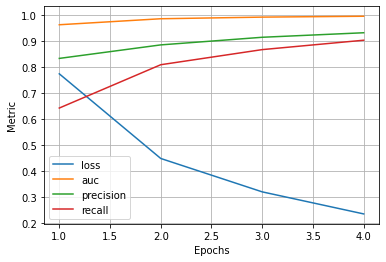

In [11]:
epochs = np.arange(1, len(history.history['loss'])+1)

plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['auc'], label='auc')
plt.plot(epochs, history.history['precision'], label='precision')
plt.plot(epochs, history.history['recall'], label='recall')


plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.grid()
plt.legend()
plt.show()

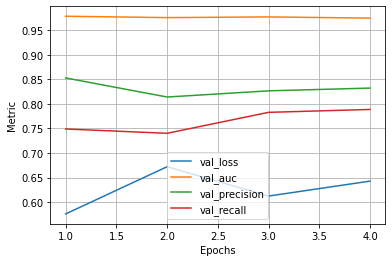

In [12]:
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.plot(epochs, history.history['val_auc'], label='val_auc')
plt.plot(epochs, history.history['val_precision'], label='val_precision')
plt.plot(epochs, history.history['val_recall'], label='val_recall')

plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.grid()
plt.legend()
plt.show()